In [1]:
# Import required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
pd.set_option("future.no_silent_downcasting", True)

In [2]:
# Read the dataset
dataset = pd.read_excel('esg-dataset.xlsx')

In [3]:
# Preview the dataset
dataset.head()

,Company,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Level,Controversy Score,ESG_Loan Approval
0,1,A,A,A,A,A,A,A,D,D,Moderate Controversy Level,2.0,High
1,2,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
2,3,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
3,4,B,B,A,A,A,C,A,A,A,None Controversy Level,NaN,High
4,5,B,B,D,A,A,A,A,A,C,Low Controversy Level,1.0,High


In [4]:
# Check the column names
dataset.columns

Index(['Company', 'EGroup1', 'EGroup2', 'EGroup3', 'EGroup4', 'Ggroup',
       'SGroup1', 'SGroup2', 'SGroup3', 'SGroup4', 'Controversy Level',
       'Controversy Score', 'ESG_Loan Approval'],
      dtype='object')

In [5]:
## Selecting the features and target variable
# Controversy Level and Controversy Score reflect the same infomation (highly correlated). So, we can drop one of them.
interested_features = ['EGroup1',
                       'EGroup2',
                       'EGroup3',
                       'EGroup4',
                       'Ggroup',
                       'SGroup1',
                       'SGroup2',
                       'SGroup3',
                       'SGroup4',
                       'Controversy Score']
target_var = 'ESG_Loan Approval'

## Exploratory Data Analysis

In [6]:
dataset_copy = dataset.copy()

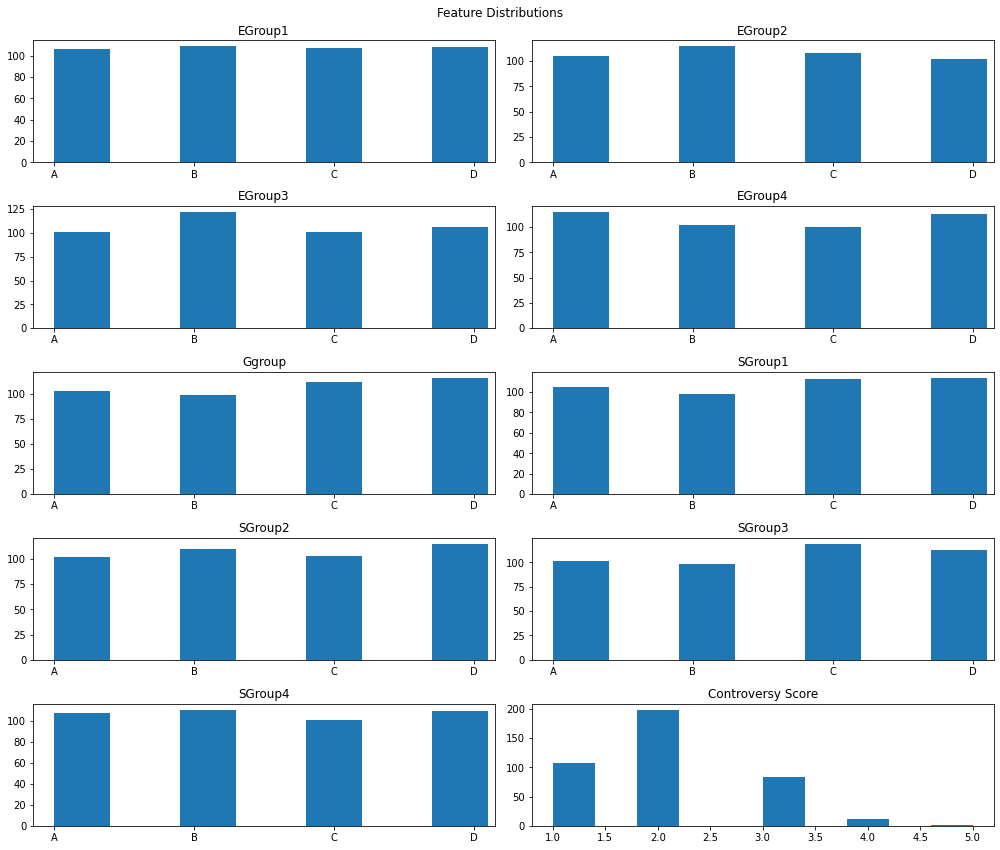

In [7]:
# Feature Distributions
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    ax = plt.subplot(5, 2, i+1)
    ax.hist(dataset_copy[feature].sort_values(), width = 0.4)
    ax.set_title(feature)
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

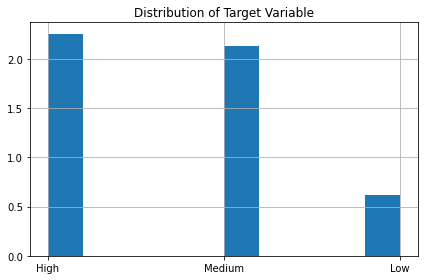

In [8]:
plt.figure()
dataset["ESG_Loan Approval"].hist(density = True)
plt.title("Distribution of Target Variable")
plt.tight_layout()
plt.show()

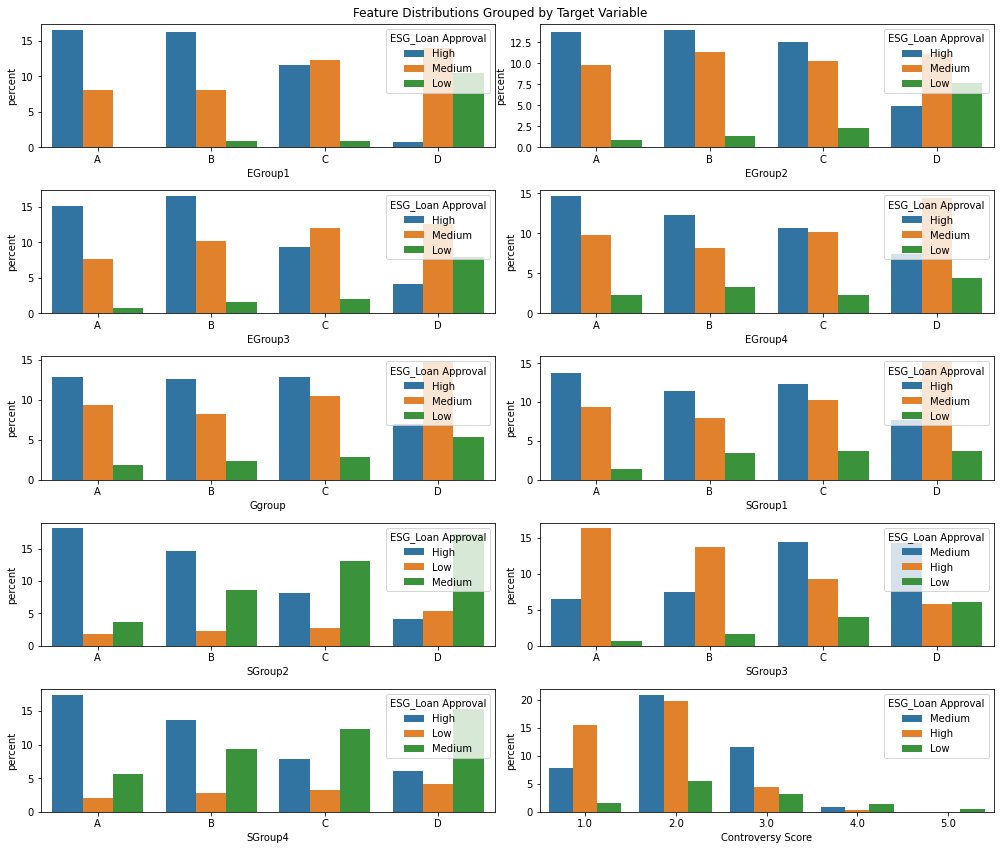

In [9]:
# Distribution of features grouping by target variable
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    plt.subplot(5, 2, i+1)
    dataset_copy = dataset_copy.sort_values(feature)
    sns.countplot(x=feature, data=dataset_copy, hue=target_var, stat = "percent")
plt.suptitle('Feature Distributions Grouped by Target Variable')
plt.tight_layout()
plt.show()

In [10]:
# transform str to int for correlation analysis
mapping = {"A": int(4), "B": int(3), "C": int(2), "D": int(1)}
for feature in interested_features:
    dataset_copy[feature] = dataset_copy[feature].replace(mapping)
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
dataset_copy["ESG_Loan Approval"]=dataset_copy["ESG_Loan Approval"].replace(target_map)

In [11]:
# exclude missing values for now
dataset_copy = dataset_copy.dropna()
# drop out the Contraversy Level column
dataset_copy = dataset_copy.drop(["Controversy Level"], axis=1)

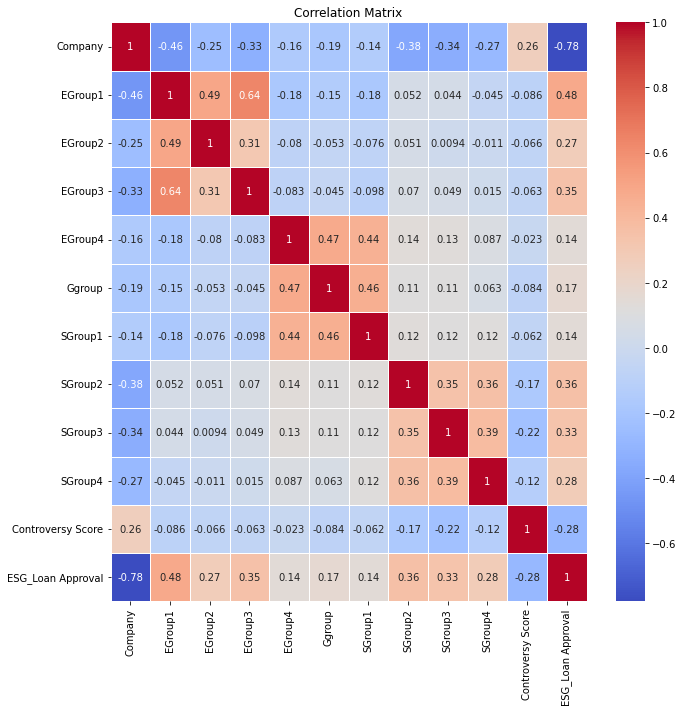

In [12]:
# Kenall Rank Correlation Matrix
corr = dataset_copy.corr(method='kendall')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Missing Value Detection and Filling

In [13]:
features = dataset[interested_features]
target = dataset[target_var]

In [14]:
# Numebr of sissing value in features
features.isnull().sum()

EGroup1               0
EGroup2               0
EGroup3               0
EGroup4               0
Ggroup                0
SGroup1               0
SGroup2               0
SGroup3               0
SGroup4               0
Controversy Score    27
dtype: int64

In [15]:
# Fill the controversy Score with the mode
mode = features["Controversy Score"].mode()[0]
features.loc[:,"Controversy Score"] = features["Controversy Score"].replace(np.nan, mode)

In [16]:
# Check the missing values again
features.isnull().sum()

EGroup1              0
EGroup2              0
EGroup3              0
EGroup4              0
Ggroup               0
SGroup1              0
SGroup2              0
SGroup3              0
SGroup4              0
Controversy Score    0
dtype: int64

## Data Transformation

In [17]:
features

,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Score
0,A,A,A,A,A,A,A,D,D,2.0
1,A,A,A,A,A,A,A,A,A,1.0
2,A,A,A,A,A,A,A,A,A,1.0
3,B,B,A,A,A,C,A,A,A,2.0
4,B,B,D,A,A,A,A,A,C,1.0
...,...,...,...,...,...,...,...,...,...,...
425,D,D,D,D,D,D,D,D,C,2.0
426,C,C,A,D,D,B,B,D,A,4.0
427,D,D,C,A,D,D,D,D,A,3.0
428,D,D,D,D,C,D,C,D,C,3.0


In [18]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features.loc[:,feature] = features[feature].replace(cat_mapping)
features = features.astype(int)

In [19]:
# Transform the target variable from categorical to numerical
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
target = target.replace(target_map).astype(int)

In [20]:
features["num_As"] = features[features.loc[:,cat_featrues]==3].count(axis=1)
features["num_Bs"] = features[features.loc[:,cat_featrues]==2].count(axis=1)
features["num_Cs"] = features[features.loc[:,cat_featrues]==1].count(axis=1)

## Modelling with SMOTE balance

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [22]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

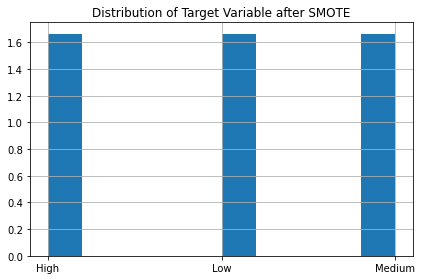

In [23]:
plt.figure()
y_train.replace({0:"Low", 1: "Medium", 2: "High"}).hist(density = True)
plt.title("Distribution of Target Variable after SMOTE")
plt.tight_layout()
plt.show()

### Logistic Regression

In [24]:
# Baseline model: Logistic Regression
logis_classifier = LogisticRegression()
param_grid = {
    'C': [5, 2, 1, 0.5, 0.1, 0.05],
    'class_weight': ['balanced', None],
    'penalty': ['none', 'l2']
}
grid_search = GridSearchCV(estimator=logis_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_


Fitting 8 folds for each of 24 candidates, totalling 192 fits
{'C': 5, 'class_weight': 'balanced', 'penalty': 'l2'}


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
pred_train_logist = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_logist)
prec_train = precision_score(y_train,pred_train_logist, average='macro')
recall_train = recall_score(y_train,pred_train_logist, average='macro')
f1_train = f1_score(y_train,pred_train_logist, average='macro')

pred_test_logist = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_logist)
prec_test = precision_score(y_test,pred_test_logist, average='macro')
recall_test = recall_score(y_test,pred_test_logist, average='macro')
f1_test = f1_score(y_test,pred_test_logist, average='macro')

In [26]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8165
Train Precision: 0.8136
Train recall: 0.8165
Train f1-score: 0.8143
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7176
Test recall: 0.7017
Test f1-score: 0.7081


# Best So Far
### Random Forest

In [27]:
# Create a random forest regressor
rf_classifier = RandomForestClassifier()
# grid search for hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ['balanced', None],
    'random_state': [11]
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_rf_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 480 candidates, totalling 3840 fits
{'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 11}


In [28]:
pred_train_rf = best_rf_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_rf)
prec_train = precision_score(y_train,pred_train_rf, average='macro')
recall_train = recall_score(y_train,pred_train_rf, average='macro')
f1_train = f1_score(y_train,pred_train_rf, average='macro')

pred_test_rf = best_rf_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_rf)
prec_test = precision_score(y_test,pred_test_rf, average='macro')
recall_test = recall_score(y_test,pred_test_rf, average='macro')
f1_test = f1_score(y_test,pred_test_rf, average='macro')

In [29]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9684
Train Precision: 0.9686
Train recall: 0.9684
Train f1-score: 0.9684
**********Test Phase**********
Test Acc: 0.8023
Test Precision: 0.8043
Test recall: 0.7312
Test f1-score: 0.7471


### XGBM

In [30]:
xgb_classifier = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [2, 5, 7],
    'subsample': [0.95, 0.75, 0.5],
    'lambda': [0.75, 0.5, 0.2],
    'alpha': [1, 0.5, 0.1],
    'eta': [0.1, 0.3, 0.5, 1],
    'max_delta_step': [0, 1, 2, 5],
    'random_state': [11]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 3888 candidates, totalling 31104 fits
{'alpha': 0.5, 'eta': 0.5, 'lambda': 0.2, 'max_delta_step': 1, 'max_depth': 7, 'n_estimators': 50, 'random_state': 11, 'subsample': 0.75}


In [31]:
pred_train_xgbm = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_xgbm)
prec_train = precision_score(y_train,pred_train_xgbm, average='macro')
recall_train = recall_score(y_train,pred_train_xgbm, average='macro')
f1_train = f1_score(y_train,pred_train_xgbm, average='macro')

pred_test_xgbm = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_xgbm)
prec_test = precision_score(y_test,pred_test_xgbm, average='macro')
recall_test = recall_score(y_test,pred_test_xgbm, average='macro')
f1_test = f1_score(y_test,pred_test_xgbm, average='macro')

In [32]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9937
Train Precision: 0.9937
Train recall: 0.9937
Train f1-score: 0.9937
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7163
Test recall: 0.6974
Test f1-score: 0.7013


### SVC

In [33]:
# SVC
svm_classifier = SVC()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_svm_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 18 candidates, totalling 144 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [34]:
pred_train_svm = best_svm_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_svm)
prec_train = precision_score(y_train, pred_train_svm, average='macro')
recall_train = recall_score(y_train, pred_train_svm, average='macro')
f1_train = f1_score(y_train, pred_train_svm, average='macro')

pred_test_svm = best_svm_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_svm)
prec_test = precision_score(y_test, pred_test_svm, average='macro')
recall_test = recall_score(y_test, pred_test_svm, average='macro')
f1_test = f1_score(y_test, pred_test_svm, average='macro')

In [35]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9789
Train Precision: 0.9789
Train recall: 0.9789
Train f1-score: 0.9789
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7845
Test recall: 0.7099
Test f1-score: 0.7232


### Gradient Boosting

In [36]:
gb_classifier = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_gb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 27 candidates, totalling 216 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [37]:
pred_train_gb = best_gb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_gb)
prec_train = precision_score(y_train, pred_train_gb, average='macro')
recall_train = recall_score(y_train, pred_train_gb, average='macro')
f1_train = f1_score(y_train, pred_train_gb, average='macro')

pred_test_gb = best_gb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_gb)
prec_test = precision_score(y_test, pred_test_gb, average='macro')
recall_test = recall_score(y_test, pred_test_gb, average='macro')
f1_test = f1_score(y_test, pred_test_gb, average='macro')

In [38]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9810
Train Precision: 0.9810
Train recall: 0.9810
Train f1-score: 0.9810
**********Test Phase**********
Test Acc: 0.7442
Test Precision: 0.7391
Test recall: 0.6790
Test f1-score: 0.6848


### KNN

In [39]:
knn_classifier = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 is for Manhattan distance, p=2 is for Euclidean distance
}
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_knn_regressor = grid_search.best_estimator_

Fitting 8 folds for each of 20 candidates, totalling 160 fits
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [40]:
pred_train_knn = best_knn_regressor.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_knn)
prec_train = precision_score(y_train, pred_train_knn, average='macro')
recall_train = recall_score(y_train, pred_train_knn, average='macro')
f1_train = f1_score(y_train, pred_train_knn, average='macro')

pred_test_knn = best_knn_regressor.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_knn)
prec_test = precision_score(y_test, pred_test_knn, average='macro')
recall_test = recall_score(y_test, pred_test_knn, average='macro')
f1_test = f1_score(y_test, pred_test_knn, average='macro')

In [41]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9937
Train Precision: 0.9938
Train recall: 0.9937
Train f1-score: 0.9937
**********Test Phase**********
Test Acc: 0.7558
Test Precision: 0.6951
Test recall: 0.6841
Test f1-score: 0.6882


### Confusion Matrix

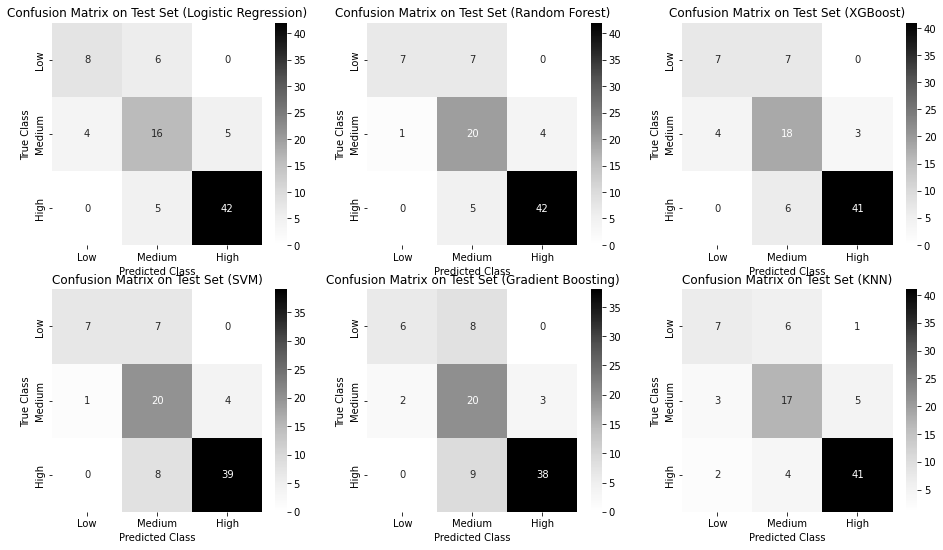

In [44]:
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}

plt.subplots(figsize=(16, 9))
ax1 = plt.subplot(2, 3, 1)
confMat=confusion_matrix(y_test, pred_test_logist)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax1=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax1.set_title('Confusion Matrix on Test Set (Logistic Regression)', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=10)
ax1.set_ylabel('True Class', fontsize=10)

ax2 = plt.subplot(2, 3, 2)
confMat=confusion_matrix(y_test, pred_test_rf)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax2=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax2.set_title('Confusion Matrix on Test Set (Random Forest)', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=10)
ax2.set_ylabel('True Class', fontsize=10)

ax3 = plt.subplot(2, 3, 3)
confMat=confusion_matrix(y_test, pred_test_xgbm)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax3=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax3.set_title('Confusion Matrix on Test Set (XGBoost)', fontsize=12)
ax3.set_xlabel('Predicted Class', fontsize=10)
ax3.set_ylabel('True Class', fontsize=10)

ax4 = plt.subplot(2, 3, 4)
confMat=confusion_matrix(y_test, pred_test_svm)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax4=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax4.set_title('Confusion Matrix on Test Set (SVM)', fontsize=12)
ax4.set_xlabel('Predicted Class', fontsize=10)
ax4.set_ylabel('True Class', fontsize=10)

ax5 = plt.subplot(2, 3, 5)
confMat=confusion_matrix(y_test, pred_test_gb)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax5=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax5.set_title('Confusion Matrix on Test Set (Gradient Boosting)', fontsize=12)
ax5.set_xlabel('Predicted Class', fontsize=10)
ax5.set_ylabel('True Class', fontsize=10)

ax6 = plt.subplot(2, 3, 6)
confMat=confusion_matrix(y_test, pred_test_knn)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax6=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax6.set_title('Confusion Matrix on Test Set (KNN)', fontsize=12)
ax6.set_xlabel('Predicted Class', fontsize=10)
ax6.set_ylabel('True Class', fontsize=10)

plt.show()